## This is the first notebook done after the hackathon
### I'm using a different approach to calculating features (more array and vector based and less row and loop based) which is speeding up the calculation. 
### The thought process is the same
#### - Justin

In [48]:
#### NOTE : I'm taking out pandas and replacing it with ray to test speed improvment!
import pandas as pd_norm
import ray
import ray.dataframe as pd
import pyarrow
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import math
welly.__version__

'0.3.0'

In [49]:
%%timeit
import os
env = %env


104 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [50]:
from IPython.display import display

In [51]:
#### Test results Part 1
#### Had to change display options to get this to print in full!
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000

AttributeError: module 'ray.dataframe' has no attribute 'set_option'

## We're going to load a pickle file of a previously created dataframe

### The dataframe merges:
1. picks_dic = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
2. picks = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
3. wells = pd.read_csv('../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
4. gis = pd.read_csv('../../well_lat_lng.csv')

### It also excludes any wells that have nulls or zeros for Top McMurray or Base McMurray picks
This was done in notebooks: 
1. notebooks_2018/mapmaking/Map_Exploration_v2-KDtree.ipynb
2. notebooks_2018/Test_RUN_2018_02/DataCleaningPrepof_KNN_neighborPickDepth_df_creation_vA_20180210

### Let's load in the pickle file of the dataframe from previous notebook mentioned above

In [11]:
wells_df_new_cleaned_plus_nn_wNoNulls =  pd_norm.read_pickle('wells_df_new_cleaned_plus_nn_wNoNulls.p')

In [ ]:
wells_df_new_cleaned_plus_nn_wNoNulls.info()

In [ ]:
wells_df_new_cleaned_plus_nn_wNoNulls.head()

In [ ]:
print(len(wells_df_new_cleaned_plus_nn_wNoNulls))

In [ ]:
wells_df_new_cleaned_plus_nn_wNoNulls.head()

In [ ]:
df_new = wells_df_new_cleaned_plus_nn_wNoNulls
# df_new["UWI (AGS)"] = df_new["UWI (AGS)_x"]
df_new["UWI"] = df_new["UWI"]
df_new["HorID"] = df_new["McMurray_Top_HorID"]
df_new["Pick"] = df_new["McMurray_Top_DEPTH"]
df_new["Quality"] = df_new["McMurray_Top_Qual"]
df_new["HorID_paleoz"] = df_new["McMurray_Base_HorID"]
df_new["Pick_paleoz"] = df_new["McMurray_Base_DEPTH"]
df_new["Quality_paleoz"] = df_new["McMurray_Base_Qual"]
df_new = df_new[["SitID","UWI","HorID","Pick","Quality","HorID_paleoz","Pick_paleoz","Quality_paleoz",'lat','lng','MM_Top_Depth_predBy_NN1thick','NN1_thickness']]
df_new

In [ ]:
print(len(df_new))

In [ ]:
#### Number of unique wells based on UWI
len(df_new.UWI.unique())

In [ ]:
df_new_test = df_new[['UWI']]

In [ ]:
print(any(df_new_test.UWI == '00/11-04-067-03W4/0'))

## Brainstorm 1 : various features to extract
1. Find average values of [each curve] in [different] length windows [above, around, below] a depth
2. Find average for [different number of] [max, min] values in [different] length windows [above, around, below] a depth for [each curve]
3. Find gradient within [window length] around a depth point 
4. Find [min, avg, max] gradient of various [smaller window length] within a larger [larger window length]
5. Find number of gradient changes (negative to positive) of various [smaller window length] within a larger [larger window length]
6. Find difference between two windows on either side of a given depth. For each window, average for [different number of] [max, min] values in [different] length windows above & below a given depth for [each curve].

In [ ]:
####
def addColWindowMean(df,col,windowSize,centered):
    featureName = col+"_mean_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).mean() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [ ]:
####
def addColWindowMax(df,col,windowSize,centered):
    featureName = col+"_max_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).max() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [ ]:
#### Returns a column with the min values of a window centered 
def addColWindowMin(df,col,windowSize,centered):
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).min() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
        #### unreverse
        
        df = df.sort_index(ascending=True)
    return df

In [ ]:
#### helper function that takes in array and an integer for the number of highest values to find the mean of 
#### example: for an array = [1,3,6,44,33,22,452] and nValues = 2, the answer would be 44+452 / 2
def nLargest(array,nValues):
    answer = np.mean(array[np.argsort(array)[-nValues:]])  
    return answer

In [ ]:
#### Returns a column with the average of the N largest values of a window 
def addColWindowAvgMaxNvalues(df,col,windowSize,centered,nValues):
    #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
    #return df
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered+"_n"+str(nValues)
    if(centered == "around"):
        #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
        df[featureName] = df[col].rolling(center=True,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        #   # df['new_column'] = df.apply(lambda x: your_function(x['High'],x['Low'],x['Close']), axis=1)
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
        #df[featureName] = df[col].rolling(center=False,window=windowSize).nlargest(nValues).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [ ]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns value
def NN1_TopMcMDepth(df,MM_Top_Depth_predBy_NN1thick):
    df['DistFrom_NN1_TopDepth'] = df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'] 
    return df


In [ ]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns *absolute* value
def NN1_TopMcMDepth_Abs(df,MM_Top_Depth_predBy_NN1thick):
    df['DistFrom_NN1_TopDepth_Abs'] = math.fabs(df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'])
    return df

In [ ]:
####
winVars = {"RangeOfCurves":['GR'],
                   "RangeOfWindows":[5,11,29],
                   "RangeOfWindowsCaution":[5],
                   "RangeOfDirection":['above','below','around'],
                   "MinOrMaxRange":['min','max'],
                   "NumbPtsRange":[1,5]}

## Read in well logs from LAS files and put into Dictionary of Dataframes. As Reading-in, add features

In [ ]:
def loadAndAddFeatures():
    count=0
    data_df=[]
    count_limit =1663
    list_of_failed_wells = []
    ### dictionary that holds every well as key:value or "UWI":df pair
    df_w_dict ={}
    while count < count_limit:
        for file in glob.glob('../../SPE_006_originalData/OilSandsDB/Logs/*.LAS'):
            #### NOTE: limiting wells being read-in to 101 here !!!!!!!!!!!!!!!!
            count+=1
            if count > count_limit:
                print("hit limit of count below file for loop")
                answer = [df_w_dict,list_of_failed_wells]
                return answer
            else:
                l_df = lasio.read(file).df()
                #print(l_df)
                str_uwi= file[-23:-4].replace("-", "/",1)[:17]+file[-6:-4].replace("-", "/",1)
                #l_df.DEPT = l_df.DEPT.astype(float)
                ##bottom_well_depth = l_df['DEPT'].max()
                if any(df_new.UWI == str_uwi):
                    if df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0] > -1:
                        l_df = l_df.reset_index()
                        print("got to UWI apppend")
                        l_df['UWI'] = str_uwi
                        print("UWI added is ",str_uwi," and type is ",type(str_uwi))
                        l_df['SitID']=df_new[df_new['UWI']==str_uwi]['SitID'].iloc[0]
#                         l_df['UWI (AGS)']=df_new[df_new['UWI']==str_uwi]['UWI (AGS)'].iloc[0]
                        l_df['Pick']=df_new[df_new['UWI']==str_uwi]['Pick'].iloc[0] 
                        l_df['HorID']=df_new[df_new['UWI']==str_uwi]['HorID'].iloc[0]
                        l_df['Quality']=df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0]
                        #### adding in paleozoic surface pick
                        l_df['Pick_paleoz']=df_new[df_new['UWI']==str_uwi]['Pick_paleoz'].iloc[0] 
                        l_df['HorID_paleoz']=df_new[df_new['UWI']==str_uwi]['HorID_paleoz'].iloc[0]
                        l_df['Quality_paleoz']=df_new[df_new['UWI']==str_uwi]['Quality_paleoz'].iloc[0]
                        
                        #### new as of 2018-02
                        l_df['MM_Top_Depth_predBy_NN1thick']=df_new[df_new['UWI']==str_uwi]['MM_Top_Depth_predBy_NN1thick'].iloc[0]
                        l_df['NN1_thickness']=df_new[df_new['UWI']==str_uwi]['NN1_thickness'].iloc[0]

                        print("got to end of col append & pick is ",l_df.Pick.unique()[0])  
                        try:
                            print("in first try statement, count = ",count)
                            float(l_df.Pick.unique()[0])
                            l_df.Pick = l_df.Pick.astype(float)
                            l_df.DEPT = l_df.DEPT.astype(float)
                            l_df['new_pick']=l_df['Pick']-l_df['DEPT']
#                             l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 1 if(x==0) else 0)
                            l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 10 if x==0 else ( 5 if (-5 < x and x <5) else 0))
#                             lambda x: x*10 if x<2 else (x**2 if x<4 else x+10)
                            #### doing the same as below but for BASE mcMurray or Paleozoic surface pick
                            float(l_df.Pick_paleoz.unique()[0])
                            l_df.Pick_paleoz = l_df.Pick_paleoz.astype(float)
                            #l_df.DEPT = l_df.DEPT.astype(float)
                            l_df['new_pick_paleoz']=l_df['Pick_paleoz']-l_df['DEPT']
                            l_df['new_pick2_paleoz']=l_df['new_pick_paleoz'].apply(lambda x: 1 if(x==0) else 0)
                            
                            #### new as of 2018-02
                            try:
                                l_df_new = NN1_TopMcMDepth(l_df,'MM_Top_Depth_predBy_NN1thick')
                            except:
                                    pass
                            try:
                                l_df_new = NN1_TopMcMDepth_Abs(l_df,'MM_Top_Depth_predBy_NN1thick')
                            except:
                                    pass
                            
                            print("got to below astype part")
                            #### instead of concat into a single dataframe, run functions & then add to dictionary   
                            ##### run functions to create features on array basis for each well in separate dataframe
                            ##### this makes certain things easier, compared to everything in a single dataframe, like making sure you don't accidentally grab data from next well up
                            ##### and will make it easier to write data back to LAS if we run into memory limitations later
                            curves = ['GR','ILD']
                            windows = [5,7,11,21]
                            directions = ["around","below","above"]
                            comboArg_A = [curves,windows,directions]
                            all_comboArgs_A = list(itertools.product(*comboArg_A))
                            for eachArgList in all_comboArgs_A:
                                try:
                                    l_df_new = addColWindowMean(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowMax(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowMin(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowAvgMaxNvalues(l_df,eachArgList[0],eachArgList[1],eachArgList[2],3)
                                except:
                                    pass
                            #### add resultant dataframe to dictionary
                            if l_df['DEPT'].max() < 600:
                                df_w_dict[l_df_new['UWI'][0]]= l_df_new
                        except ValueError as e:
                            print("e = ",e)
                            print ('Error picking')
                            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
                            message = template.format(type(e).__name__, e.args)
                            print("message = ",message)
                            print("file = ",file)
                            print("Got except, UWI added is ",str_uwi," and type is ",type(str_uwi))
                            list_of_failed_wells.append(str_uwi)
                            #continue;
                    else:
                        pass
                else:
                    pass
            #print("result = ",df_w_dict)
    #else: 
    #    return df_w_dict, list_of_failed_wells
    answer = [df_w_dict,list_of_failed_wells]
    
    return answer

In [ ]:
## %timeit
answer = loadAndAddFeatures()

In [ ]:
#answer=[df_w_dict,list_of_failed_wells]
df_w_dict = answer[0]
list_of_failed_wells = answer[1]

In [ ]:
#### dumping dict of data frame to pickle file
wells_and_features_20180210 = df_w_dict
pickle.dump(wells_and_features_20180210, open( "dict_of_df_wells_and_features_class3_20180211.p", "wb" ) )

In [ ]:
df_w_dict =  pd.read_pickle('dict_of_df_wells_and_features_class3_20180211.p')

### NOTE: not all well logs were read-in successfully, need to go back and find out why

In [ ]:
#print(df_w_dict)

In [ ]:
print("list_of_failed_wells",list_of_failed_wells)

In [ ]:
df_w_dict['00/04-13-077-05W4/0']

In [ ]:
## testing one dataframe of one well in dictionary of all that were successfully read in
df_w_dict['00/01-03-085-15W4/0'].shape

In [ ]:
print(len(df_w_dict))

## Turn dictionary of dataframes into single dataframe

In [ ]:
def turnDictofDFtoDF(dict_of_df):
    data_df = pd.DataFrame()
    list_of_df = []
    values = dict_of_df.values()
    for each in values:
        list_of_df.append(each)
    data_df = pd.concat(list_of_df)
    return data_df
        

In [ ]:
data_df = turnDictofDFtoDF(df_w_dict)
data_df.shape

In [ ]:
type(data_df)

In [ ]:
#### dumpingdata frame to pickle file
df_wells_and_features_20180210 = data_df
pickle.dump(df_wells_and_features_20180210, open( "df_wells_and_features_class3_20180211_qual_all.p", "wb" ) )

### Load that same pickle

In [17]:
data_df =  pd_norm.read_pickle('df_wells_and_features_class3_20180211_qual_all.p')

In [18]:
data_df

,CALI,COND,DELT,DEPT,DPHI,DT,DistFrom_NN1_TopDepth,GR,GR_max_11winSize_dirabove,GR_max_11winSize_diraround,...,Quality_paleoz,RHOB,SFLU,SP,SitID,UWI,new_pick,new_pick2,new_pick2_paleoz,new_pick_paleoz
0,NaN,NaN,NaN,135.00,0.290,NaN,187.00,96.787,NaN,NaN,...,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,181.00,0,0,212.00
1,NaN,NaN,NaN,135.25,0.294,NaN,186.75,98.011,NaN,NaN,...,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,180.75,0,0,211.75
2,NaN,NaN,NaN,135.50,0.294,NaN,186.50,98.615,NaN,NaN,...,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,180.50,0,0,211.50
3,NaN,NaN,NaN,135.75,0.287,NaN,186.25,99.836,NaN,NaN,...,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,180.25,0,0,211.25
4,NaN,NaN,NaN,136.00,0.283,NaN,186.00,99.817,NaN,NaN,...,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,180.00,0,0,211.00
5,NaN,NaN,NaN,136.25,0.283,NaN,185.75,99.188,NaN,99.836,...,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,179.75,0,0,210.75
6,NaN,NaN,NaN,136.50,0.281,NaN,185.50,97.949,NaN,99.836,...,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,179.50,0,0,210.50
7,NaN,NaN,NaN,136.75,0.280,NaN,185.25,95.468,NaN,100.335,...,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,179.25,0,0,210.25
8,NaN,NaN,NaN,137.00,0.275,NaN,185.00,93.606,NaN,100.939,...,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,179.00,0,0,210.00
9,NaN,NaN,NaN,137.25,0.267,NaN,184.75,92.974,NaN,100.939,...,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,178.75,0,0,209.75


In [20]:
paleozoic_pick_test = data_df['new_pick_paleoz'][1800:2000]
paleozoic_pick_test

939      0.25
940      0.00
941     -0.25
942     -0.50
943     -0.75
944     -1.00
945     -1.25
946     -1.50
947     -1.75
948     -2.00
949     -2.25
950     -2.50
951     -2.75
952     -3.00
953     -3.25
954     -3.50
955     -3.75
956     -4.00
957     -4.25
958     -4.50
959     -4.75
960     -5.00
0      277.00
1      276.75
2      276.50
3      276.25
4      276.00
5      275.75
6      275.50
7      275.25
        ...  
148    240.00
149    239.75
150    239.50
151    239.25
152    239.00
153    238.75
154    238.50
155    238.25
156    238.00
157    237.75
158    237.50
159    237.25
160    237.00
161    236.75
162    236.50
163    236.25
164    236.00
165    235.75
166    235.50
167    235.25
168    235.00
169    234.75
170    234.50
171    234.25
172    234.00
173    233.75
174    233.50
175    233.25
176    233.00
177    232.75
Name: new_pick_paleoz, Length: 200, dtype: float64

## Key variables that hold data frame column names

In [21]:
keys = ['ILD','DPHI','GR','NPHI','CALI','COND','DELT','RHOB','PHIN','DT','ILM','SP','SFLU','IL','DEPTH','DEPH','MD']

In [22]:
keys2 = ['ILD','DPHI','GR','NPHI','CALI','RHOB']

Adding deritive features

In [23]:
# All Column Names
all_col = list(data_df)
all_col

['CALI',
 'COND',
 'DELT',
 'DEPT',
 'DPHI',
 'DT',
 'DistFrom_NN1_TopDepth',
 'GR',
 'GR_max_11winSize_dirabove',
 'GR_max_11winSize_diraround',
 'GR_max_21winSize_dirabove',
 'GR_max_21winSize_diraround',
 'GR_max_5winSize_dirabove',
 'GR_max_5winSize_diraround',
 'GR_max_7winSize_dirabove',
 'GR_max_7winSize_diraround',
 'GR_mean_11winSize_dirabove',
 'GR_mean_11winSize_diraround',
 'GR_mean_21winSize_dirabove',
 'GR_mean_21winSize_diraround',
 'GR_mean_5winSize_dirabove',
 'GR_mean_5winSize_diraround',
 'GR_mean_7winSize_dirabove',
 'GR_mean_7winSize_diraround',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_

In [24]:
col_to_ignore = ["DistFrom_NN1_TopDepth_Abs",'Quality',"Quality_paleoz","UWI",'HorID','HorID_paleoz','SitID','new_pick',"Pick",'Pick_paleoz','new_pick2','new_pick2_paleoz','new_pick_paleoz']

In [25]:
def findFeatureCol(all_col,col_to_ignore):
    main_list = np.setdiff1d(all_col,col_to_ignore)
    return main_list

In [26]:
features2 = findFeatureCol(all_col,col_to_ignore)
features2

array(['CALI', 'COND', 'DELT', 'DEPT', 'DPHI', 'DT',
       'DistFrom_NN1_TopDepth', 'GR', 'GR_max_11winSize_dirabove',
       'GR_max_11winSize_diraround', 'GR_max_21winSize_dirabove',
       'GR_max_21winSize_diraround', 'GR_max_5winSize_dirabove',
       'GR_max_5winSize_diraround', 'GR_max_7winSize_dirabove',
       'GR_max_7winSize_diraround', 'GR_mean_11winSize_dirabove',
       'GR_mean_11winSize_diraround', 'GR_mean_21winSize_dirabove',
       'GR_mean_21winSize_diraround', 'GR_mean_5winSize_dirabove',
       'GR_mean_5winSize_diraround', 'GR_mean_7winSize_dirabove',
       'GR_mean_7winSize_diraround', 'GR_min_11winSize_dirabove',
       'GR_min_11winSize_dirabove_n3', 'GR_min_11winSize_diraround',
       'GR_min_11winSize_diraround_n3', 'GR_min_21winSize_dirabove',
       'GR_min_21winSize_dirabove_n3', 'GR_min_21winSize_diraround',
       'GR_min_21winSize_diraround_n3', 'GR_min_5winSize_dirabove',
       'GR_min_5winSize_dirabove_n3', 'GR_min_5winSize_diraround',
       'GR

In [33]:
ray.init()

Waiting for redis server at 127.0.0.1:15450 to respond...
Waiting for redis server at 127.0.0.1:46661 to respond...
Starting local scheduler with the following resources: {'GPU': 0, 'CPU': 8}.

View the web UI at http://localhost:8889/notebooks/ray_ui74541.ipynb?token=533e9f9f3e49f71d508c8e0aafe6981af49b7c4f7ea62e0a



{'local_scheduler_socket_names': ['/tmp/scheduler26481314'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store12851593', manager_name='/tmp/plasma_manager40194422', manager_port=39136)],
 'redis_address': '127.0.0.1:15450',
 'webui_url': 'http://localhost:8889/notebooks/ray_ui74541.ipynb?token=533e9f9f3e49f71d508c8e0aafe6981af49b7c4f7ea62e0a'}

In [34]:
label = 'new_pick2'
train_X2 = ray.put(data_df[features2])
train_y = ray.put(data_df[label])


In [35]:
train_X2.shape

AttributeError: 'common.ObjectID' object has no attribute 'shape'

In [29]:
# from xgboost.sklearn import XGBRegressor

# model2 = XGBRegressor()
# model2.fit(train_X2, train_y)
# result2= model2.predict(train_X2)
# result2

In [36]:
from xgboost.sklearn import XGBClassifier

model2 = XGBClassifier()
model2.fit(train_X2, train_y)
result2= model2.predict(train_X2)
result2

/Users/justingosses/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ValueError: bad input shape ()

In [46]:
well_data=data_df.copy()

In [47]:
well_data = ray.put(well_data)

ArrowIOError: Broken pipe

In [38]:
well_data.shape

(922272, 93)

In [39]:
id_array = well_data['SitID'].unique()
id_array_permutation = np.random.permutation(id_array)
train_index = id_array_permutation[:int(len(id_array)*.8)]
test_index = id_array_permutation[int(len(id_array)*.8)+1:]
train_df = well_data.loc[well_data['SitID'].isin(train_index)]
test_df = well_data.loc[well_data['SitID'].isin(test_index)]

In [40]:

label = 'new_pick2'

In [41]:
seed = 123

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
from xgboost.sklearn import XGBClassifier
# from xgboost.sklearn import XGBRegressor
#params_final = (
#    gamma=0, 
#    alpha=0.2, 
#    maxdepth=3, 
#    subsample=0.8, 
#    colsamplebytree= 0.8, 
#    n_estimators= 100, 
#    learningrate= 0.1, 
#    minchildweight= 1
#)
train_X = train_df[features2]
train_y = train_df[label]
test_X = test_df[features2]
test_y = test_df[label]

In [44]:
model = XGBClassifier(
    gamma=0, 
    reg_alpha=0.2, 
    max_depth=3, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3)
model.fit(train_X,train_y)
result = model.predict(test_X)
result

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/justingosses/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-3f9ca4147f19>", line 10, in <module>
    model.fit(train_X,train_y)
  File "/Users/justingosses/anaconda/lib/python3.5/site-packages/xgboost/sklearn.py", line 445, in fit
    verbose_eval=verbose)
  File "/Users/justingosses/anaconda/lib/python3.5/site-packages/xgboost/training.py", line 205, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/Users/justingosses/anaconda/lib/python3.5/site-packages/xgboost/training.py", line 76, in _train_internal
    bst.update(dtrain, i, obj)
  File "/Users/justingosses/anaconda/lib/python3.5/site-packages/xgboost/core.py", line 806, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle, iteration, dtrain.handle))
KeyboardInterrupt

During handling of the above exception, another exception occ

KeyboardInterrupt: 

In [ ]:
test_df_pred = test_df.copy()
test_df_pred['Pick_pred'] = result
test_df_pred.head()

### Now run model on all wells to generate new Pick_pred column from formation classification prediction that will be used regression model run

In [ ]:
#### Run model on all wells to get a result for a new column / features
result = model.predict(data_df[features2])
data_df_w_clas_pred = data_df.copy()
data_df_w_clas_pred['Pick_pred'] = result
#### Now that there is a classification prediction (basically )

In [ ]:
data_df_w_clas_pred

In [ ]:
#### save result as pickle
pickle.dump(data_df_w_clas_pred, open("data_df_w_clas_pred_ClassPredAllGoodWells_20180218.p", "wb" ) )

In [52]:
#### read pickle
data_df_w_clas_pred =  pd_norm.read_pickle('data_df_w_clas_pred_ClassPredAllGoodWells_20180218.p')

In [53]:
# All Column Names
all_col = list(data_df_w_clas_pred)
all_col

['CALI',
 'COND',
 'DELT',
 'DEPT',
 'DPHI',
 'DT',
 'DistFrom_NN1_TopDepth',
 'GR',
 'GR_max_11winSize_dirabove',
 'GR_max_11winSize_diraround',
 'GR_max_21winSize_dirabove',
 'GR_max_21winSize_diraround',
 'GR_max_5winSize_dirabove',
 'GR_max_5winSize_diraround',
 'GR_max_7winSize_dirabove',
 'GR_max_7winSize_diraround',
 'GR_mean_11winSize_dirabove',
 'GR_mean_11winSize_diraround',
 'GR_mean_21winSize_dirabove',
 'GR_mean_21winSize_diraround',
 'GR_mean_5winSize_dirabove',
 'GR_mean_5winSize_diraround',
 'GR_mean_7winSize_dirabove',
 'GR_mean_7winSize_diraround',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_

In [54]:
col_to_ignore = ["DistFrom_NN1_TopDepth_Abs",'Quality',"Quality_paleoz","UWI",'HorID','HorID_paleoz','SitID','new_pick',"Pick",'Pick_paleoz','new_pick2','new_pick2_paleoz','new_pick_paleoz']

In [55]:
features2 = findFeatureCol(all_col,col_to_ignore)
features2

array(['CALI', 'COND', 'DELT', 'DEPT', 'DPHI', 'DT',
       'DistFrom_NN1_TopDepth', 'GR', 'GR_max_11winSize_dirabove',
       'GR_max_11winSize_diraround', 'GR_max_21winSize_dirabove',
       'GR_max_21winSize_diraround', 'GR_max_5winSize_dirabove',
       'GR_max_5winSize_diraround', 'GR_max_7winSize_dirabove',
       'GR_max_7winSize_diraround', 'GR_mean_11winSize_dirabove',
       'GR_mean_11winSize_diraround', 'GR_mean_21winSize_dirabove',
       'GR_mean_21winSize_diraround', 'GR_mean_5winSize_dirabove',
       'GR_mean_5winSize_diraround', 'GR_mean_7winSize_dirabove',
       'GR_mean_7winSize_diraround', 'GR_min_11winSize_dirabove',
       'GR_min_11winSize_dirabove_n3', 'GR_min_11winSize_diraround',
       'GR_min_11winSize_diraround_n3', 'GR_min_21winSize_dirabove',
       'GR_min_21winSize_dirabove_n3', 'GR_min_21winSize_diraround',
       'GR_min_21winSize_diraround_n3', 'GR_min_5winSize_dirabove',
       'GR_min_5winSize_dirabove_n3', 'GR_min_5winSize_diraround',
       'GR

In [24]:
id_array = data_df_w_clas_pred['SitID'].unique()
id_array_permutation = np.random.permutation(id_array)
train_index = id_array_permutation[:int(len(id_array)*.8)]
test_index = id_array_permutation[int(len(id_array)*.8)+1:]
train_df = data_df_w_clas_pred.loc[data_df_w_clas_pred['SitID'].isin(train_index)]
test_df = data_df_w_clas_pred.loc[data_df_w_clas_pred['SitID'].isin(test_index)]

In [26]:
label = 'new_pick2'
train_X_r = train_df[features2]
train_y_r = train_df[label]
test_X_r = test_df[features2]
test_y_r = test_df[label]

In [27]:
from xgboost.sklearn import XGBRegressor

model_r = XGBRegressor()
model_r.fit(train_X_r, train_y_r)
result_r= model_r.predict(train_X_r)
result_r

/Users/justingosses/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([0.0043191 , 0.0043191 , 0.0043191 , ..., 0.05782515, 0.05782515,
       0.05782515], dtype=float32)

In [56]:
len(result_r)

NameError: name 'result_r' is not defined

In [29]:
len(data_df_w_clas_pred)

922272

In [30]:
len(train_df)

738974

In [57]:
train_df_pred = train_df.copy()

In [32]:
train_df_pred['Pick_pred_reg'] = result_r

In [49]:
train_df_pred[20:60]

,CALI,COND,DELT,DEPT,DPHI,DT,DistFrom_NN1_TopDepth,GR,GR_max_11winSize_dirabove,GR_max_11winSize_diraround,GR_max_21winSize_dirabove,GR_max_21winSize_diraround,GR_max_5winSize_dirabove,GR_max_5winSize_diraround,GR_max_7winSize_dirabove,GR_max_7winSize_diraround,GR_mean_11winSize_dirabove,GR_mean_11winSize_diraround,GR_mean_21winSize_dirabove,GR_mean_21winSize_diraround,GR_mean_5winSize_dirabove,GR_mean_5winSize_diraround,GR_mean_7winSize_dirabove,GR_mean_7winSize_diraround,GR_min_11winSize_dirabove,GR_min_11winSize_dirabove_n3,GR_min_11winSize_diraround,GR_min_11winSize_diraround_n3,GR_min_21winSize_dirabove,GR_min_21winSize_dirabove_n3,GR_min_21winSize_diraround,GR_min_21winSize_diraround_n3,GR_min_5winSize_dirabove,GR_min_5winSize_dirabove_n3,GR_min_5winSize_diraround,GR_min_5winSize_diraround_n3,GR_min_7winSize_dirabove,GR_min_7winSize_dirabove_n3,GR_min_7winSize_diraround,GR_min_7winSize_diraround_n3,HorID,HorID_paleoz,ILD,ILD_max_11winSize_dirabove,ILD_max_11winSize_diraround,ILD_max_21winSize_dirabove,ILD_max_21winSize_diraround,ILD_max_5winSize_dirabove,ILD_max_5winSize_diraround,ILD_max_7winSize_dirabove,ILD_max_7winSize_diraround,ILD_mean_11winSize_dirabove,ILD_mean_11winSize_diraround,ILD_mean_21winSize_dirabove,ILD_mean_21winSize_diraround,ILD_mean_5winSize_dirabove,ILD_mean_5winSize_diraround,ILD_mean_7winSize_dirabove,ILD_mean_7winSize_diraround,ILD_min_11winSize_dirabove,ILD_min_11winSize_dirabove_n3,ILD_min_11winSize_diraround,ILD_min_11winSize_diraround_n3,ILD_min_21winSize_dirabove,ILD_min_21winSize_dirabove_n3,ILD_min_21winSize_diraround,ILD_min_21winSize_diraround_n3,ILD_min_5winSize_dirabove,ILD_min_5winSize_dirabove_n3,ILD_min_5winSize_diraround,ILD_min_5winSize_diraround_n3,ILD_min_7winSize_dirabove,ILD_min_7winSize_dirabove_n3,ILD_min_7winSize_diraround,ILD_min_7winSize_diraround_n3,ILM,MM_Top_Depth_predBy_NN1thick,NN1_thickness,NPHI,PHID,Pick,Pick_paleoz,Quality,Quality_paleoz,RHOB,SFLU,SP,SitID,UWI,new_pick,new_pick2,new_pick2_paleoz,new_pick_paleoz,Pick_pred,Pick_pred_reg
20,NaN,NaN,NaN,140.00,0.237,NaN,182.00,102.702,102.702,104.527,102.702,105.084,102.702,104.527,102.702,104.527,100.297636,102.644818,98.834524,102.083905,101.4928,102.7012,101.329714,102.701286,94.811,101.891000,100.889,104.509000,92.974,101.891000,94.811,105.077000,100.889,101.891000,101.481,103.511667,100.889,101.891000,100.889,104.115667,13000,14000,3.829,3.829,3.901,3.829,4.276,3.829,3.901,3.829,3.901,3.284636,3.532182,3.084524,3.467143,3.4262,3.6794,3.397714,3.615571,3.057,3.579333,3.230,3.852000,2.735,3.579333,3.057,4.002000,3.230,3.556667,3.291,3.852000,3.230,3.579333,3.230,3.852000,NaN,322.0,25.0,0.500,NaN,316.0,347.0,1,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,176.00,0,0,207.00,0,-0.038172
21,NaN,NaN,NaN,140.25,0.238,NaN,181.75,103.306,103.306,105.084,103.306,105.084,103.306,104.527,103.306,104.527,101.069909,103.023909,99.144952,102.394190,101.9736,103.3060,101.669143,103.128857,97.881,102.499333,100.889,104.708333,92.974,102.499333,97.881,105.077000,100.889,102.499333,101.481,104.115667,100.889,102.499333,101.481,104.307667,13000,14000,3.901,3.901,3.901,3.901,4.883,3.901,3.901,3.901,3.901,3.361182,3.536727,3.134762,3.554000,3.5602,3.7576,3.475143,3.670000,3.057,3.760000,3.230,3.852000,2.735,3.760000,3.057,4.353333,3.230,3.760000,3.550,3.852000,3.230,3.760000,3.291,3.852000,NaN,322.0,25.0,0.494,NaN,316.0,347.0,1,2,NaN,NaN,NaN,154369,00/10-16-082-14W4/0,175.75,0,0,206.75,0,-0.038172
22,NaN,NaN,NaN,140.50,0.243,NaN,181.50,104.527,104.527,105.084,104.527,105.084,104.527,104.527,104.527,104.527,101.674091,103.403545,99.455238,102.440381,102.7012,103.7862,102.185286,103.556857,100.335,103.511667,100.889,104.896333,92.974,103.511667,98.851,105.077000,101.481,103.511667,102.702,104.307667,100.889,103.511667,101.481,104.509000,13000,14000,3.826,3.901,3.901,3.901,6.132,3.901,3.901,3.901,3.901,3.431091,3.546909,3.181476,3.700429,3.6794,3.7698,3.551143,3.686857,3.057,3.852000,3.230,3.852000,2.735,3.852000,3.057,5.097000,3.291,3.852000,

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

idx = train_df_pred.groupby(['SitID'])['Pick_pred_reg'].transform(max) == train_df_pred['Pick_pred_reg']
train_df_pred_max=train_df_pred[idx]



In [50]:
train_df_pred_max[20:60]

,CALI,COND,DELT,DEPT,DPHI,DT,DistFrom_NN1_TopDepth,GR,GR_max_11winSize_dirabove,GR_max_11winSize_diraround,GR_max_21winSize_dirabove,GR_max_21winSize_diraround,GR_max_5winSize_dirabove,GR_max_5winSize_diraround,GR_max_7winSize_dirabove,GR_max_7winSize_diraround,GR_mean_11winSize_dirabove,GR_mean_11winSize_diraround,GR_mean_21winSize_dirabove,GR_mean_21winSize_diraround,GR_mean_5winSize_dirabove,GR_mean_5winSize_diraround,GR_mean_7winSize_dirabove,GR_mean_7winSize_diraround,GR_min_11winSize_dirabove,GR_min_11winSize_dirabove_n3,GR_min_11winSize_diraround,GR_min_11winSize_diraround_n3,GR_min_21winSize_dirabove,GR_min_21winSize_dirabove_n3,GR_min_21winSize_diraround,GR_min_21winSize_diraround_n3,GR_min_5winSize_dirabove,GR_min_5winSize_dirabove_n3,GR_min_5winSize_diraround,GR_min_5winSize_diraround_n3,GR_min_7winSize_dirabove,GR_min_7winSize_dirabove_n3,GR_min_7winSize_diraround,GR_min_7winSize_diraround_n3,HorID,HorID_paleoz,ILD,ILD_max_11winSize_dirabove,ILD_max_11winSize_diraround,ILD_max_21winSize_dirabove,ILD_max_21winSize_diraround,ILD_max_5winSize_dirabove,ILD_max_5winSize_diraround,ILD_max_7winSize_dirabove,ILD_max_7winSize_diraround,ILD_mean_11winSize_dirabove,ILD_mean_11winSize_diraround,ILD_mean_21winSize_dirabove,ILD_mean_21winSize_diraround,ILD_mean_5winSize_dirabove,ILD_mean_5winSize_diraround,ILD_mean_7winSize_dirabove,ILD_mean_7winSize_diraround,ILD_min_11winSize_dirabove,ILD_min_11winSize_dirabove_n3,ILD_min_11winSize_diraround,ILD_min_11winSize_diraround_n3,ILD_min_21winSize_dirabove,ILD_min_21winSize_dirabove_n3,ILD_min_21winSize_diraround,ILD_min_21winSize_diraround_n3,ILD_min_5winSize_dirabove,ILD_min_5winSize_dirabove_n3,ILD_min_5winSize_diraround,ILD_min_5winSize_diraround_n3,ILD_min_7winSize_dirabove,ILD_min_7winSize_dirabove_n3,ILD_min_7winSize_diraround,ILD_min_7winSize_diraround_n3,ILM,MM_Top_Depth_predBy_NN1thick,NN1_thickness,NPHI,PHID,Pick,Pick_paleoz,Quality,Quality_paleoz,RHOB,SFLU,SP,SitID,UWI,new_pick,new_pick2,new_pick2_paleoz,new_pick_paleoz,Pick_pred,Pick_pred_reg,Pred_ClassRegres_Diff
758,NaN,NaN,NaN,488.204,0.241,NaN,-4.554,87.679,89.581,94.442,92.209,111.019,89.581,91.818,89.581,94.442,76.080727,84.460545,81.164381,86.555190,81.9428,88.4458,77.182571,87.668429,63.332,88.228000,63.332,92.871333,63.332,91.130667,63.332,108.799333,68.022,88.228000,85.727,89.692667,63.332,88.228000,77.008,91.947000,13000,14000,11.896,13.514,13.514,13.514,13.514,13.478,12.469,13.514,13.121,11.571636,12.039000,9.089952,10.740381,12.6098,11.9078,12.709714,12.010286,7.892,13.371000,10.146,13.371000,5.745,13.371000,7.514,13.371000,11.896,13.022667,11.466,12.150000,11.896,13.371000,11.412,12.558333,NaN,483.65,40.00,0.420,NaN,491.95,523.65,3,1,NaN,NaN,NaN,109947,00/10-30-076-14W4/0,3.746,5,0,35.446,5,3.986546,484.458
759,NaN,NaN,NaN,488.454,0.233,NaN,-4.804,85.727,89.581,97.010,92.209,111.019,89.581,94.442,89.581,94.442,77.048818,87.522182,81.250143,88.191571,85.4838,89.8494,79.824714,89.764286,63.332,88.228000,68.022,94.602000,63.332,91.130667,63.332,109.834667,77.008,88.228000,85.727,91.947000,63.332,88.228000,85.727,92.646333,13000,14000,11.623,13.514,13.478,13.514,13.514,13.121,12.085,13.514,12.469,11.910818,11.686727,9.312571,10.715333,12.2388,11.6964,12.598000,11.738571,8.948,13.371000,9.639,13.022667,5.745,13.371000,7.366,13.371000,11.623,12.558333,11.412,11.868000,11.623,13.371000,11.219,12.150000,NaN,483.65,40.00,0.415,NaN,491.95,523.65,3,1,NaN,NaN,NaN,109947,00/10-30-076-14W4/0,3.496,5,0,35.196,5,3.986546,484.958
660,152.737,NaN,NaN,495.000,0.269,NaN,-1.000,57.662,114.001,99.643,114.058,114.001,99.643,85.448,99.643,97.199,87.676818,61.385818,91.549571,68.026476,82.2770,56.9642,84.516429,60.434857,57.662,104.747333,26.217,96.928667,57.662,113.506667,22.304,104.747333,57.662,94.096667,32.871,71.514333,57.662,96.928667,32.871,84.693333,13000,14000,5.352,6.011,7.279,6.011,7.279,5.933,6.396,6.011,6.861,5.192636,6.029182,4.720762,5.379190,5.3380,5.5026,5.502857,5.696571,4.029,5.921000,4.868,7.120667,3.762,5.921000

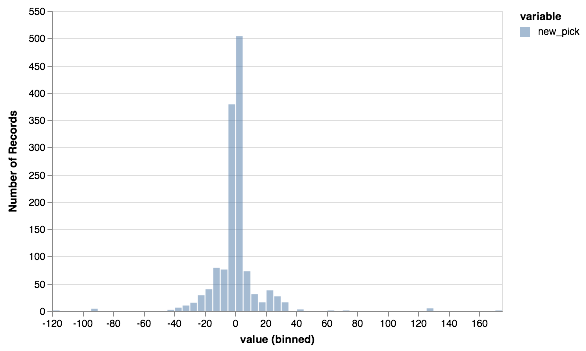

In [51]:
import pdvega
import vega
# 'MM_Top_Depth_predBy_NN1thick'
test_df_pred2_TopScratch2 = train_df_pred_max[['new_pick']]
test_df_pred2_TopScratch2.vgplot.hist(bins=100, alpha=0.5)

In [53]:
# Score
from sklearn.metrics import mean_squared_error
final_score = np.sqrt(mean_squared_error(train_df_pred_max['DEPT'],train_df_pred_max['Pick']))
print("Prediction RMSE: {}".format(final_score))

Prediction RMSE: 15.545960727910046


In [54]:
#### dumpingdata frame that has gone through both classifier & then regessor to pickle file
df_wells_and_features_20180210 = data_df
pickle.dump(df_wells_and_features_20180210, open( "df_wells_and_features_class3_class_then_regr_20180218.p", "wb" ) )

# ENDED HERE

In [38]:
print(4)

4


In [46]:
train_df_pred_max['Pred_ClassRegres_Diff'] = train_df_pred_max['DEPT'] - train_df_pred_max['new_pick']

/Users/justingosses/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
# train_df_pred_max.head()

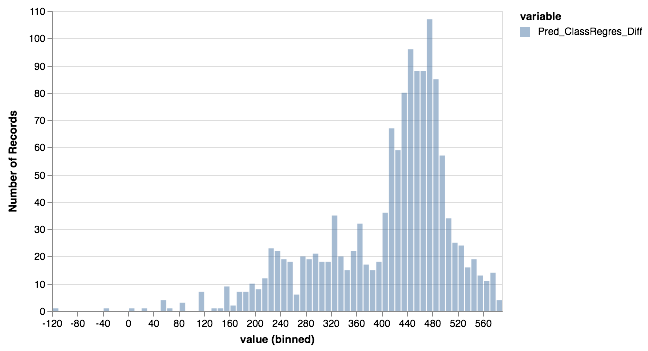

In [48]:
test_df_pred2_TopScratch2 = train_df_pred_max[['Pred_ClassRegres_Diff']]
test_df_pred2_TopScratch2.vgplot.hist(bins=100, alpha=0.5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# make predictions for test data
# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_df_pred['new_pick2'], test_df_pred['Pick_pred'])

In [ ]:
accuracy

In [ ]:
test_df_pred_onlyTopMCM_class5 = test_df_pred.loc[test_df_pred['new_pick2'] == 5]

In [ ]:
print(len(test_df_pred_onlyTopMCM))
#test_df_pred_onlyTopMCM

In [ ]:
accuracy = accuracy_score(test_df_pred_onlyTopMCM_class5['new_pick2'], test_df_pred_onlyTopMCM_class5['Pick_pred'])
accuracy

In [ ]:
# 'MM_Top_Depth_predBy_NN1thick'
test_df_pred2_TopScratch2 = test_df_pred_onlyTopMCM_class5[['DistFrom_NN1_TopDepth']]
test_df_pred2_TopScratch2.vgplot.hist(bins=100, alpha=0.5)

In [ ]:
test_df_pred_onlyTopMCM_class10 = test_df_pred.loc[test_df_pred['new_pick2'] == 10]

In [ ]:
print(len(test_df_pred_onlyTopMCM_class10))

In [ ]:
accuracy_class10 = accuracy_score(test_df_pred_onlyTopMCM_class10['new_pick2'], test_df_pred_onlyTopMCM_class10['Pick_pred'])
accuracy_class10

In [ ]:
# 'MM_Top_Depth_predBy_NN1thick'
test_df_pred2_TopScratch2 = test_df_pred_onlyTopMCM_class10[['DistFrom_NN1_TopDepth']]
test_df_pred2_TopScratch2.vgplot.hist(bins=100, alpha=0.5)

In [ ]:
plt.plot(test_df_pred_onlyTopMCM_class10['DEPT'],test_df_pred_onlyTopMCM_class10['Pick_pred'], 'ro')

In [ ]:
plt.plot(test_df_pred_onlyTopMCM_class10['DEPT'],test_df_pred_onlyTopMCM_class10['DistFrom_NN1_TopDepth'], 'ro')

In [ ]:
#c='McMurray_Base_DEPTH'
test_df_pred_onlyTopMCM_class5.vgplot(kind='scatter', x='DEPT', y='Pick',c='NN1_thickness')

In [ ]:
#c='McMurray_Base_DEPTH'
test_df_pred_onlyTopMCM_class10.vgplot(kind='scatter', x='DEPT', y='Pick',c='NN1_thickness')

In [ ]:
test_df_pred_onlyTopMCM_class5.vgplot(kind='scatter', x='DEPT', y='Pick_pred',c='NN1_thickness')

In [ ]:
test_df_pred_onlyTopMCM_class10pred = test_df_pred.loc[test_df_pred['Pick_pred'] == 10]
len(test_df_pred_onlyTopMCM_class10pred)

In [ ]:
test_df_pred[0:20]

In [ ]:
len(test_df_pred.UWI.unique())

In [ ]:
idx = test_df_pred.groupby(['SitID'])['Pick_pred'].transform(max) == test_df_pred['Pick_pred']
test_df_pred3=test_df_pred[idx]
        
        


In [ ]:
len(test_df_pred3)

In [ ]:
# Score
final_score = np.sqrt(mean_squared_error(test_df_pred2['DEPT'],test_df_pred3['Pick']))
print("Prediction RMSE: {}".format(final_score))

In [ ]:
plt.plot(test_df_pred2['DEPT'],test_df_pred2['Pick'], 'ro')

In [ ]:
plt.scatter(test_df_pred2['DEPT'],test_df_pred2['Pick'], s=2)
plt.plot(test_df_pred2['DEPT'],test_df_pred2['DEPT'], 'ro')
#plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 'k--', lw=2)
plt.xlabel('True Measured')
plt.ylabel('Predicted Depth')

In [ ]:
import pdvega
import vega

In [ ]:
test_df_pred2

In [ ]:
# 'MM_Top_Depth_predBy_NN1thick'
test_df_pred2_TopScratch2 = test_df_pred2[['DistFrom_NN1_TopDepth']]
test_df_pred2_TopScratch2.vgplot.hist(bins=100, alpha=0.5)

In [ ]:
#c='McMurray_Base_DEPTH'
test_df_pred2.vgplot(kind='scatter', x='DEPT', y='Pick',c='NN1_thickness')

In [ ]:
#c='McMurray_Base_DEPTH'
test_df_pred2.vgplot(kind='scatter', x='DEPT', y='Pick',c='Quality')